# MRT Line 3 Passenger Traffic (2012-2014) Analysis

[Dataset Link](http://data.gov.ph/dataset/metro-rail-transit-line-3-passenger-traffic-daily)

# Notes

- for this dataset the day starts at *03:00* and ends at *02:59*
- for **2014** data it ends on **august 31**
- for every station their are **entry** and **exit** value

## Questions

- [What station has the highest number of people to enter and drop-off?](#What-station-has-the-highest-number-of-people-to-enter-and-drop-off?)
- [What day usually people use MRT?](#What-day-usually-people-use-MRT?)
- [For every hour what station has the highest number of people to enter and leave?](#For-every-hour-what-station-has-the-highest-number-of-people-to-enter-and-leave?)
- What direction usually people go? From north to south or vice versa?
- What percentage of people in metro manila are using mrt?
- Does holidays affect mrt traffic?
- Does payday affect mrt traffic?


## Graphs

- Yearly line graph of daily traffic of mrt
- Line graph of traffic of every station per year
- 


## Model

- Create model to predict the number of people to entry and exit in a station for a specific hour


In [127]:
import datetime
from itertools import groupby

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [128]:
# import datasets
data_2012 = pd.read_csv('datasets/metro-rail-transit-line-3-passenger-traffic-daily-All-2017-10-28_2023/2012_mrt_hourly_daily_ridership 2.csv')
data_2013 = pd.read_csv('datasets/metro-rail-transit-line-3-passenger-traffic-daily-All-2017-10-28_2023/2013_mrt_hourly_daily_ridership.csv')
data_2014 = pd.read_csv('datasets/metro-rail-transit-line-3-passenger-traffic-daily-All-2017-10-28_2023/2014_mrt_hourly_daily_ridership.csv')

In [129]:
# add year for each data_*
# so when i merge this later on i still have a reference for the year
data_2012['year'] = 2012
data_2013['year'] = 2013
data_2014['year'] = 2014

In [130]:
# remove unnecessary columns in data_2012 so the columns are the same with data_2013 and data_2014
del data_2012['Unnamed: 29']
del data_2012['Unnamed: 30']

In [131]:
# check if the columns of 3 datasets are the same
data_2012.columns.tolist() == data_2013.columns.tolist() == data_2013.columns.tolist()

True

In [132]:
# for data_2013, some of the day column has only a value in the start of the day
# in order to solve this

current_day = 1

def get_day(day):
    # set global_current to use in this scope
    global current_day
    
    # when day is null return the current_day (last day that occured)
    if pd.isnull(day):
        return current_day
    
    # when day is not null store it in current_day (last day that occured)
    current_day = day
    
    return current_day

data_2013['day'] = data_2013['day'].apply(lambda d: get_day(d))

In [133]:
# check if there still null in data_2013['day']
set(data_2013['day'].isnull())

{False}

In [134]:
# update data_2013 day columns to integer
data_2013['day'] = data_2013['day'].apply(lambda d: int(d))

In [135]:
# merge datasets
dataset = pd.concat([data_2012, data_2013, data_2014])
dataset = dataset.reset_index(drop=True)

In [136]:
entry_columns = [station for station in dataset.columns if 'entry' in station]
exit_columns = [station for station in dataset.columns if 'exit' in station]
stations = entry_columns + exit_columns
stations.sort()

In [137]:
# for every station column change "-" values to 0
for station in stations:
    dataset[station] = dataset[station].apply(lambda n: n if str(n).isdigit() else 0)

In [138]:
# change stations column type to numeric
dataset[stations] = dataset[stations].apply(pd.to_numeric)

In [139]:
# remove range in time column add rename it to hour
dataset['hour'] = dataset['time'].apply(lambda h: int(h[:2]))
del dataset['time']

In [140]:
# trim month
dataset['month'] = dataset['month'].apply(lambda m: m.strip())

In [141]:
# fix day column cause for this dataset day starts at 03:00 and ends at 02:59
first_row_string = ' '.join(str(v) for v in dataset[['year', 'month', 'day', 'hour']].loc[0].values)
start_date = datetime.datetime.strptime(first_row_string, '%Y %B %d %H')
current_date = start_date

def get_true_datetime(date):
    global current_date
    
    if date.hour == 0:
        current_date = current_date + datetime.timedelta(days=1)

    return [
        current_date.year,
        current_date.month,
        current_date.day,
        date.hour
    ]

dataset[['year', 'month', 'day', 'hour']] = dataset[['year', 'month', 'day', 'hour']].apply(lambda r: get_true_datetime(r), axis=1)

In [142]:
# add timestamp column
dataset['timestamp'] = dataset[['year', 'month', 'day', 'hour']].apply(lambda r: datetime.datetime(r.year, r.month, r.day, r.hour), axis=1)

del dataset['year']
del dataset['month']
del dataset['day']
del dataset['hour']

In [143]:
dataset = dataset.set_index('timestamp', drop=False)

In [144]:
#dataset.ix['2012-02-01':'2012-02-01'][['shaw_blvd_entry', 'shaw_blvd_exit']].plot(figsize=(30, 10))

## What station has the highest number of people to enter and drop-off?

**Taft Avenue Station** has the highest number of people to enter in the train followed by **North Avenue Station**. This make sense cause they are terminal stations.

**Taft Avenue Station** has the highest number of people to drop-off in the train followed by **Cubao Station**. Same reason as the other one.

**Cubao station** is connected to **LRT Line 2** and I think people use cubao to transfer to other line.

In [145]:
# get median of every entry and exit column
stations_median = dataset[stations].median()

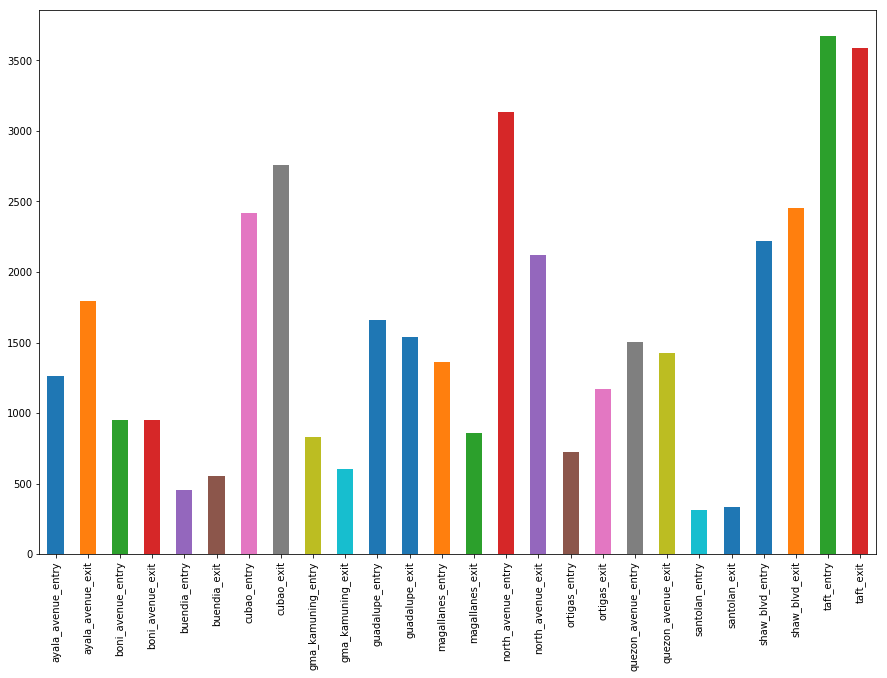

In [146]:
stations_median.plot(kind='bar', figsize=(15, 10))

## What day usually has the highest number of people to use MRT?

**Wednesday** has the highest number of people to use MRT but it has a very little difference for the rest of the weekdays.

Comparing to **Friday** the traffic for **Saturday** went down by **9.75%** but it's still relatively high.

Comparing to **Saturday** the traffic for **Sunday** went down by **31.70%**.

In [147]:
# get entry and exit columns for every station
# from: https://stackoverflow.com/questions/24310945/group-items-by-string-pattern-in-python
keyf = lambda text: text.split('_')[0]
group_stations = [list(items) for gr, items in groupby(sorted(stations), key=keyf)]
group_stations = [{ 'name': keyf(stations[0]), 'stations': stations } for stations in group_stations]

In [148]:
# create weekday column from timestamp
dataset['weekday'] = dataset['timestamp'].apply(lambda x: x.strftime('%A'))

In [150]:
# group all entries by weekday and get the median
weekday_df = dataset.groupby('weekday').agg('median')

In [151]:
# get the mean of the entry and exit columns for every station
for group in group_stations:
    weekday_df[group['name']] = weekday_df[group['stations']].mean(axis=1)
    
    for station in group['stations']:
        del weekday_df[station]

In [152]:
weekday_df_mean = weekday_df.mean(axis=1)
weekday_df_mean

weekday
Friday       1723.038462
Monday       1773.461538
Saturday     1555.000000
Sunday       1062.500000
Thursday     1795.057692
Tuesday      1792.750000
Wednesday    1885.153846
dtype: float64

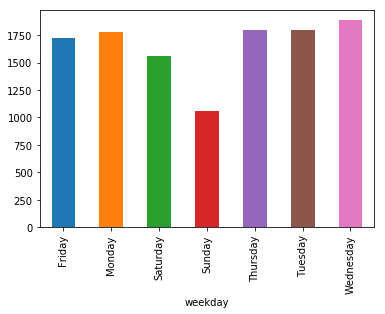

In [153]:
weekday_df_mean.plot(kind='bar')

## For every hour what station has the highest number of people to enter and leave?

@TODO: answer

In [190]:
hour_df = dataset.groupby(dataset['timestamp'].dt.hour).median().T
entry_hour_df = dataset.groupby(dataset['timestamp'].dt.hour)[entry_columns].median().T
exit_hour_df = dataset.groupby(dataset['timestamp'].dt.hour)[exit_columns].median().T

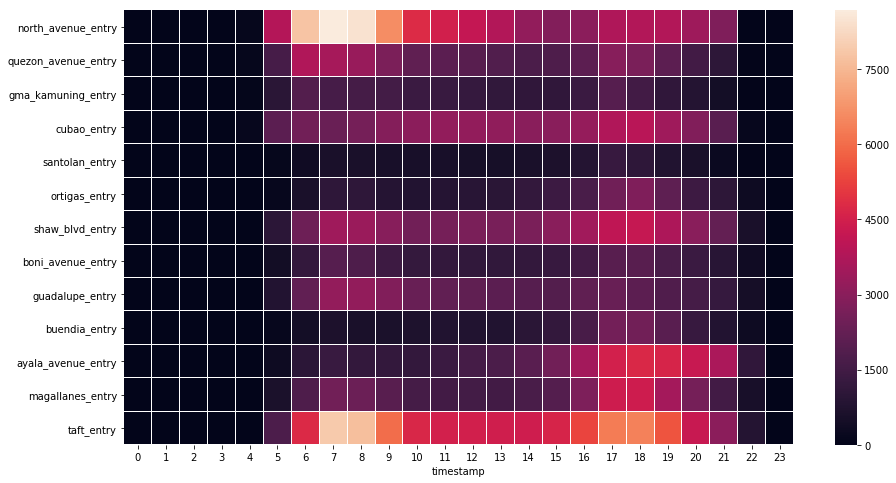

In [191]:
f, ax = plt.subplots(figsize=(15, 8))
sb.heatmap(entry_hour_df, annot=False, ax=ax, linewidths=.01)

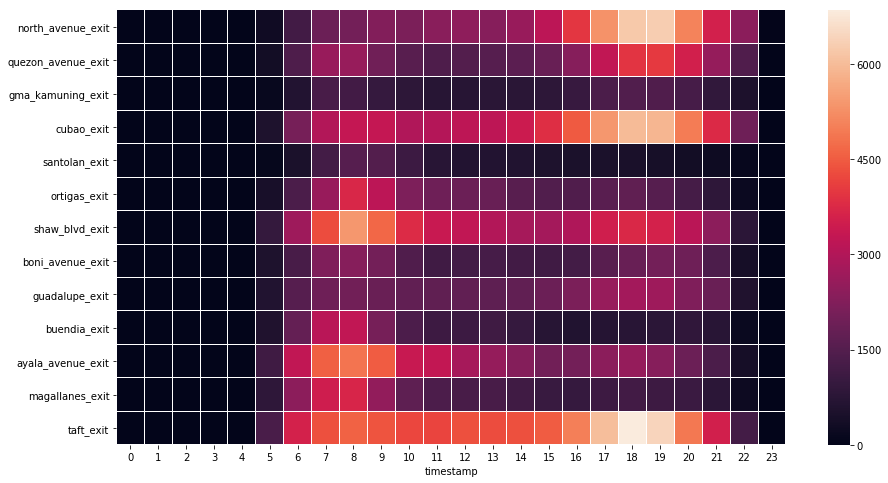

In [192]:
f, ax = plt.subplots(figsize=(15, 8))
sb.heatmap(exit_hour_df, annot=False, ax=ax, linewidths=.01)

In [194]:
# add line plot for every station to compare the entry and exit